# Essentials

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces

with open('c_states_dict_v4.pkl', 'rb') as f:
    c_states = pickle.load(f)

print(c_states.keys())
print(c_states[5].shape)

with open('c_states_dict_acer_2.pkl', 'rb') as f:
    c_states_test = pickle.load(f)
    
print(c_states_test.keys())

# with open('c_states_dict_exp.pkl', 'rb') as f:
#     c_states_exp = pickle.load(f)

# print(c_states_exp.keys())
# print(c_states_exp[1,1].shape)

with open('c_states_dict_exp_filt.pkl', 'rb') as f:
    c_states_exp_filt = pickle.load(f)

print(c_states_exp_filt.keys())
print(c_states_exp_filt[1,1].shape)


# PD-SNR (SNR +/- 0.5)
with open('c_states_dict_acer_v3.pkl', 'rb') as f:
    c_states = pickle.load(f)

print(c_states.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'c_states_dict_v4.pkl'

In [4]:

with open('../database/c_states_dict_acer_v3.pkl', 'rb') as f:
    c_states_test = pickle.load(f)
    
print(c_states_test.keys())
print(c_states_test[0].shape)



dict_keys([10, 9.5, 9, 8.5, 8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5, -5, -5.5, -6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5, -12, -12.5, -13, -13.5, -14, -14.5, -15, -15.5, -16, -16.5, -17, -17.5, -18, -18.5, -19, -19.5, -20, -20.5, -21, -21.5, -22, -22.5, -23, -23.5, -24, -24.5, -25])
(500, 18, 7, 100)


In [6]:
from sklearn.model_selection import KFold

# Perform 5-fold cross-validation
kf = KFold(n_splits=5)

snr = 10
data = c_states_test[snr]
fold = 0

for train_index, test_index in kf.split(data):
    fold += 1
    print(f'Fold {fold}, \nshape_train: {data[train_index].shape}, \nshape_test: {data[test_index].shape}')


Fold 1, 
shape_train: (400, 18, 7, 100), 
shape_test: (100, 18, 7, 100)
Fold 2, 
shape_train: (400, 18, 7, 100), 
shape_test: (100, 18, 7, 100)
Fold 3, 
shape_train: (400, 18, 7, 100), 
shape_test: (100, 18, 7, 100)
Fold 4, 
shape_train: (400, 18, 7, 100), 
shape_test: (100, 18, 7, 100)
Fold 5, 
shape_train: (400, 18, 7, 100), 
shape_test: (100, 18, 7, 100)


In [ ]:
class FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode

        focus_measure = self.data[self.current_episode, frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()

        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]
        
        if episode != -1:
            self.current_episode = episode

        reward = 0
        kp_fp = 1
        fp_des = 0.01

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}

        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            current_ep_prog = 100
            
            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)
                
            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )*current_ep_prog/100
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)
            current_ep_prog =100

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +(kp_fp*(np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))*current_ep_prog/100
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-kp_fp*fp-fn+tn

            truncated = False

        return self.state, reward, epsiode_terminated, truncated, info
    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode=='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

In [ ]:
class TEST_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(TEST_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[self.current_episode, frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.01

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass


In [ ]:
class EVAL_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(EVAL_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes =  data.shape[2]-1
        self.frequencies = data.shape[0]-1
        self.measures = data.shape[1]
        self.windows = data.shape[2]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[nf, :, window] for nf in noise_frequencies]
         
        # measures = my_norm(np.concatenate(([focus_measure], noise_measures), axis=0).flatten())
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.01

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

In [11]:
class EVAL_FINETUNE_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(EVAL_FINETUNE_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes =  data.shape[2]-1
        self.frequencies = data.shape[0]-1
        self.measures = data.shape[1]
        self.windows = data.shape[2]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[nf, :, window] for nf in noise_frequencies]
         
        # measures = my_norm(np.concatenate(([focus_measure], noise_measures), axis=0).flatten())
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
            
            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +((np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2), 
                    'tp_hist:':self.tpr_hist,'fp_hist:':self.fpr_hist}
            
            # print(info)
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        # reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

In [9]:
class EVAL_NOTRUE_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(EVAL_NOTRUE_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes =  data.shape[2]-1
        self.frequencies = data.shape[0]-1
        self.measures = data.shape[1]
        self.windows = data.shape[2]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[nf, :, window] for nf in noise_frequencies]
         
        # measures = my_norm(np.concatenate(([focus_measure], noise_measures), axis=0).flatten())
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
            
            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +((np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2), 
                    'tp_hist:':self.tpr_hist,'fp_hist:':self.fpr_hist}
            
            # print(info)
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        # reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

In [ ]:
def retrain(snr):
    data = c_states[snr]

    # Train PPO model
    env = FrequencyDetectionEnv(data)
    model_ppo = PPO.load('comp_ppo_snr5-5.zip', env=env)
    model_ppo.learn(total_timesteps=timesteps)
    model_ppo.save('comp_ppo_snr5-5.zip')
    _, latest = env.reset()
    print('\nPPO:')
    print(latest)

    # Train DQN model
    env = FrequencyDetectionEnv(data)
    model_dqn = DQN.load('comp_dqn_snr5-5.zip', env=env)
    model_dqn.learn(total_timesteps=timesteps)
    model_dqn.save('comp_dqn_snr5-5.zip')
    _, latest = env.reset()
    print('\nDQN:')
    print(latest)

    env = FrequencyDetectionEnv(data)
    model_a2c = A2C.load('comp_a2c_snr5-5.zip', env=env)
    model_a2c.learn(total_timesteps=timesteps)
    model_a2c.save('comp_a2c_snr5-5.zip')
    _, latest = env.reset()
    print('\nA2C:')
    print(latest)

    return model_ppo, model_dqn, model_a2c

In [ ]:
def my_evaluate_model(model, env, num_episodes=50,model_name = 'ppo'):
    tpr_hist = []
    fpr_hist = []
    rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        obs = obs[0]
        done = False
        total_reward = 0
        tpr_episode = []
        fpr_episode = []
        ep = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # bs, reward, terminated, truncated, info 
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if not np.isnan(info['tp_rate']):
                tpr_episode.append(info['tp_rate'])
                fpr_episode.append(info['fp_rate'])
                # print(info)
                done = True
    
        # if model_name == 'dqn':
        #     model.train(gradient_steps=10)
        # else:
        #     model.train()
        tpr_hist.append(np.mean(tpr_episode))
        fpr_hist.append(np.mean(fpr_episode))
        rewards.append(total_reward)

    return tpr_hist, fpr_hist, rewards

In [ ]:
ntotal = len(c_states.keys())
resdict4 = dict()
for i,snr in enumerate(c_states.keys()):
    print(f'{i+1}/{ntotal}')
    data = c_states[snr]
    # env = DummyVecEnv([lambda: FrequencyDetectionEnv(data)])
    eval_env = TEST_FrequencyDetectionEnv(data)
    model_ppo = PPO.load('final_comp_ppo_snr5-5.zip', env = env)
    model_dqn = DQN.load('final_comp_dqn_snr5-5.zip', env = env)
    model_a2c = A2C.load('final_comp_a2c_snr5-5.zip', env = env)


    
    num_episodes = 5

    # Evaluate both models
    timesteps = (data.shape[0]()
    model_ppo.learn(total_timesteps=timesteps)
    tpr_ppo, fpr_ppo, rewards_ppo = my_evaluate_model(model_ppo, eval_env,num_episodes=num_episodes)

    model_ppo.learn(total_timesteps=timesteps)
    tpr_dqn, fpr_dqn, rewards_dqn = my_evaluate_model(model_dqn, eval_env,model_name='dqn',num_episodes=num_episodes)
    tpr_a2c, fpr_a2c, rewards_a2c = my_evaluate_model(model_a2c, eval_env,num_episodes=num_episodes)

    resdict4[snr] = {
        'TPR':{
            'PPO':tpr_ppo,
            'DQN':tpr_dqn,
            'A2C':tpr_a2c, 
        },
        'FPR':{
            'PPO':fpr_ppo,
            'DQN':fpr_dqn,
            'A2C':fpr_a2c
        },  
        'REW':{
            'PPO':rewards_ppo,
            'DQN':rewards_dqn,
            'A2C':rewards_a2c
        }        
    }

In [ ]:
resdict3 = dict()
for i,snr in enumerate(c_states.keys()):
    # print(f'{i+1}/{ntotal}')
    data = c_states[snr]
    # print(data.shape)
    
    h0_csm = c_states[snr][:,9:,0,3:].ravel()
    h1_csm = c_states[snr][:,:9,0,3:].ravel()

    h0_gft = c_states[snr][:,9:,1,3:].ravel()
    h1_gft = c_states[snr][:,:9,1,3:].ravel()

    h0_msc = c_states[snr][:,9:,2,3:].ravel()
    h1_msc = c_states[snr][:,:9,2,3:].ravel()

    cv_csm = np.quantile(10**np.random.choice(h0_csm,size = 8*100, replace= False),1-0.05)
    cv_gft = np.quantile(10**np.random.choice(h0_gft,size = 8*100, replace= False),1-0.05)
    cv_msc = np.quantile(10**np.random.choice(h0_msc,size = 8*100, replace= False),1-0.05)    

    resdict3[snr] = {
        'TPR':{
            'CSM':100*np.sum(np.where(10**h1_csm>=cv_csm,1,0))/len(h1_csm),
            'GFT':100*np.sum(np.where(10**h1_gft>=cv_gft,1,0))/len(h1_gft),
            'MSC':100*np.sum(np.where(10**h1_msc>=cv_msc,1,0))/len(h1_msc), 
        },
        'FPR':{
            'CSM':100*np.sum(np.where(10**h0_csm>=cv_csm,1,0))/len(h0_csm),
            'GFT':100*np.sum(np.where(10**h0_gft>=cv_gft,1,0))/len(h0_gft),
            'MSC':100*np.sum(np.where(10**h0_msc>=cv_msc,1,0))/len(h0_msc)
        }       
    }    


In [ ]:
# Fine-tune the pretrained model
intensidades = ['70','60','50','40','30']

seen = {}
for iint in range(1,6):
    for ivol in range(1,12):
        seen[ivol, iint] = 0

for iint in range(1,6):
    print(f'Intensidade: {intensidades[iint-1]} dB')
    
    # Only 1st voluntary used on pretraining
    ivol = np.random.randint(1,11)
    seen[ivol, iint] = 1

    data = c_states_exp_filt[ivol,iint] 
    env = EVAL_FINETUNE_FrequencyDetectionEnv(data)
    obs, info = env.reset()
     
    if iint ==1: # On first run, initialize model as copy of pretrained
        model = DQN.load('../models/final_comp_dqn_snr5-5.zip', env=env) # mini_dqn_snr5.zip # final_comp_dqn_snr5-5.zip
        # model = DQN.load('mini_dqn_snr0.zip', env=env)
    else:
        model = DQN.load('new_exp_retrain_comp_dqn_snr5-5.zip', env=env) # exp_retrain2_mini_snr5.zip # exp_retrain_comp_dqn_snr5-5.zip
        # model = DQN.load('exp_retrain2_mini_snr5.zip', env=env)

    model.learn((data.shape[2]-1)*(data.shape[0]-1))
    obs, info = env.reset()
    # hist_tp.append(info['tp_rate'])
    # hist_fp.append(info['fp_rate'])
    # print(info)

    model.save('new_exp_retrain_comp_dqn_snr5-5.zip')
    # model.save('exp_retrain2_mini_snr5.zip')

# Validate the trained model
hist_tpr_dqn = []
hist_fpr_dqn = [] 
for iint in range(1,6):
    print(f'Intensidade: {intensidades[iint-1]} dB')
    for ivol in range(1,12):
        if not(seen[ivol, iint] == 1):
        
            data = c_states_exp_filt[ivol,iint] 
            env = EVAL_NOTRUE_FrequencyDetectionEnv(data)
            obs, info = env.reset()

            model = DQN.load('new_exp_retrain_comp_dqn_snr5-5.zip', env=env)
            # model = DQN.load('exp_retrain2_mini_snr5.zip', env=env)

            for test_episode in range((data.shape[2]-1)*(data.shape[0]-1)):
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)

                if terminated:
                    obs, info = env.reset()
                    hist_tpr_dqn.append(info['tp_rate'])
                    hist_fpr_dqn.append(info['fp_rate'])
                    # print(info)
                env.close()

print(f'TPR:{np.mean(hist_tpr_dqn)}')
print(f'FPR:{np.mean(hist_fpr_dqn)}')
# print(hist_fpr_dqn)
# print(hist_fpr_dqn)

In [153]:
# 1hr long code runtime exec
import pickle
import numpy as np
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from stable_baselines3 import DQN, PPO, A2C

# Load data
with open('../database/c_states_dict_exp_filt.pkl', 'rb') as f:
    c_states_exp_filt = pickle.load(f)

# Function to fine-tune the model
def fine_tune_model(model_class, pretrained_model_path, save_model_path, data, reset_model):
    env = EVAL_FINETUNE_FrequencyDetectionEnv(data)
    
    if reset_model == True:  # On first run, initialize model as copy of pretrained
        model = model_class.load(pretrained_model_path, env=env)
    else:
        model = model_class.load(save_model_path, env=env)

    model.learn((data.shape[2] - 1) * (data.shape[0] - 1))
    model.save(save_model_path)
    return model

# Function to validate the model
def validate_model(model_class, save_model_path, data, hist_tpr, hist_fpr):
    env = EVAL_NOTRUE_FrequencyDetectionEnv(data)
    obs, info = env.reset()

    model = model_class.load(save_model_path, env=env)

    for test_episode in range((data.shape[2] - 1) * (data.shape[0] - 1)):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated:
            obs, info = env.reset()
            hist_tpr.append(info['tp_rate'])
            hist_fpr.append(info['fp_rate'])
            env.close()

    return hist_tpr,hist_fpr

# Function to run cross-validation
def cross_validate_model(model_class, pretrained_model_path, save_model_path, k_folds=5):

    # cv_results = {fold: {iint: {}} for iint in range(1, 12) for fold in range(1, k_folds+1)}
    cv_results = {}
    for fold in range(1, 6):
        cv_results[fold] = {iint:{} for iint in range(1,6)}
    cv_results_preview = {'tpr':[],'fpr':[]}
    intensidades = ['70', '60', '50', '40', '30']

    # For each fold
    for fold in range(1, k_folds+1):

        # For every intensity
        for iint in range(1, 6):
            print(f'Intensidade: {intensidades[iint-1]} dB')
            hist_tpr = []
            hist_fpr = []

            # Take one random voluntary as fine-tuning instance, and 10 others as validation
            train_index, test_index = train_test_split(np.arange(1,12), train_size=1)

            # Fine-tune once
            for ivol in train_index:
                data = c_states_exp_filt[ivol, iint]
                fine_tune_model(model_class, pretrained_model_path, save_model_path, data, 
                                reset_model = True # resets model at start of each intensity
                                )

            # Test in 10 other voluntaries
            for ivol in test_index:
                    data = c_states_exp_filt[ivol, iint]
                    validate_model(model_class, save_model_path, data, hist_tpr, hist_fpr)

            cv_results[fold][iint]['tpr'] = hist_tpr
            cv_results[fold][iint]['fpr'] = hist_fpr

        cv_results_preview['tpr'].append(np.mean(hist_tpr))
        cv_results_preview['fpr'].append(np.mean(hist_fpr))

    mtpr = np.mean(cv_results_preview['tpr'])
    stpr = np.std(cv_results_preview['tpr']) 
    mfpr = np.mean(cv_results_preview['fpr'])
    sfpr = np.std(cv_results_preview['fpr']) 
    print(f'Final TPR: { mtpr } +/- { stpr }')
    print(f'Final FPR: { mfpr } +/- { sfpr }')

    return cv_results, cv_results_preview

# Fine-tune and validate models
cv_dqn, cvp_dqn = cross_validate_model(DQN, '../models/final_comp_dqn_snr5-5.zip', '../models/cv-new_exp_retrain_comp_dqn_snr5-5.zip',5)
cv_ppo, cvp_ppo = cross_validate_model(PPO, '../models/final_comp_ppo_snr5-5.zip', '../models/cv-new_exp_retrain_comp_ppo_snr5-5.zip',5)
cv_a2c, cvp_a2c = cross_validate_model(A2C, '../models/final_comp_a2c_snr5-5.zip', '../models/cv-new_exp_retrain_comp_a2c_snr5-5.zip',5)

Intensidade: 70 dB
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Intensidade: 60 dB
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrap

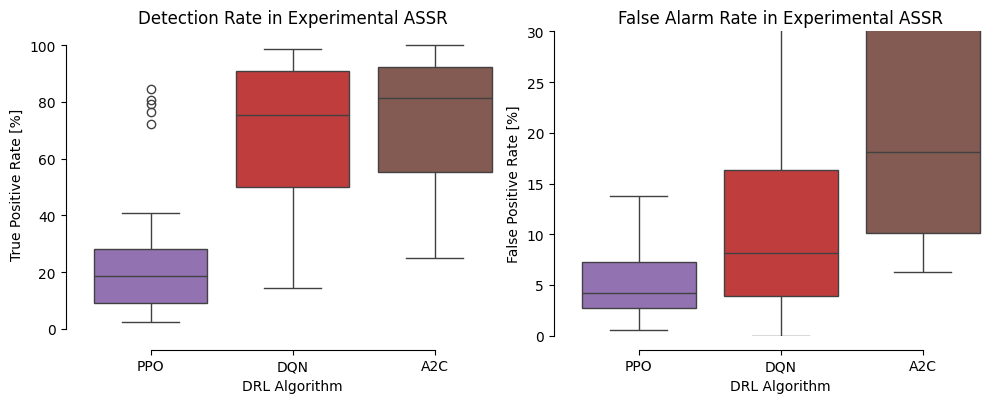

In [173]:
import seaborn as sns
import pandas as pd

def get_fold_metrics(cv_dict,intensity, metric, prev = False):
    collected_metric = []
    for fold in cv_dict.keys():
        if not(prev):
            for val in cv_dict[fold][intensity][metric]:
                collected_metric.append(val)
        else:
            for val in cv_dict[fold][1][metric]:
                collected_metric.append(val)

    return collected_metric

tpr = pd.DataFrame({'PPO':get_fold_metrics(cv_ppo, 1, 'tpr', True),
                    'DQN':get_fold_metrics(cv_dqn, 1, 'tpr', True),
                    'A2C':get_fold_metrics(cv_a2c, 1, 'tpr', True)})

fpr = pd.DataFrame({'PPO':get_fold_metrics(cv_ppo, 1, 'fpr', True),
                    'DQN':get_fold_metrics(cv_dqn, 1, 'fpr', True),
                    'A2C':get_fold_metrics(cv_a2c, 1, 'fpr', True)})

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.boxplot(tpr,palette=['tab:purple', 'tab:red', 'tab:brown'])
plt.title('Detection Rate in Experimental ASSR')
plt.ylabel('True Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.tight_layout()

plt.subplot(122)
sns.boxplot(fpr,palette=['tab:purple', 'tab:red', 'tab:brown'])
plt.title('False Alarm Rate in Experimental ASSR')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.ylim([0,30])
plt.tight_layout()
sns.despine(offset=10, trim=True)
plt.show()

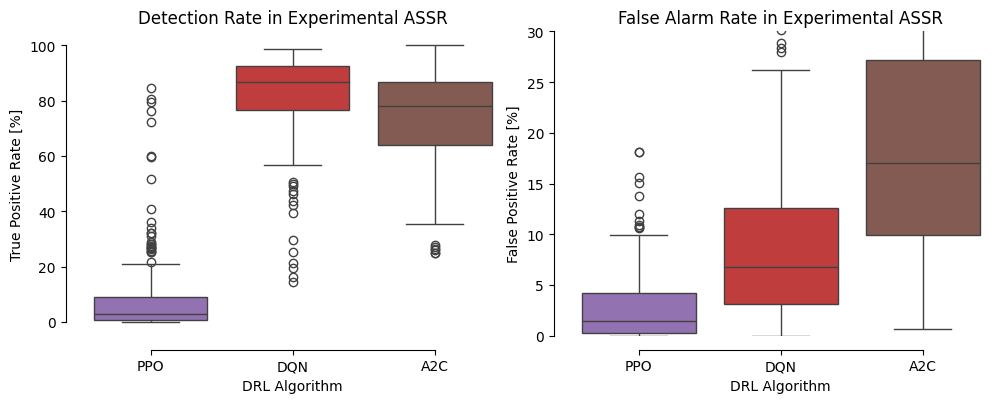

In [175]:

def get_fold_metrics(cv_dict,intensity, metric, prev = False):
    collected_metric = []
    for fold in cv_dict.keys():
        if not(prev):
            for intensity in np.arange(1,6):
                for val in cv_dict[fold][intensity][metric]:
                    collected_metric.append(val)
        else:
            for val in cv_dict[fold][1][metric]:
                collected_metric.append(val)

    return collected_metric

inten = 4
tpr = pd.DataFrame({'PPO':get_fold_metrics(cv_ppo, inten, 'tpr'),
                    'DQN':get_fold_metrics(cv_dqn, inten, 'tpr'),
                    'A2C':get_fold_metrics(cv_a2c, inten, 'tpr')})

fpr = pd.DataFrame({'PPO':get_fold_metrics(cv_ppo, inten, 'fpr'),
                    'DQN':get_fold_metrics(cv_dqn, inten, 'fpr'),
                    'A2C':get_fold_metrics(cv_a2c, inten, 'fpr')})

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.boxplot(tpr,palette=['tab:purple', 'tab:red', 'tab:brown'])
plt.title('Detection Rate in Experimental ASSR')
plt.ylabel('True Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.tight_layout()

plt.subplot(122)
sns.boxplot(fpr,palette=['tab:purple', 'tab:red', 'tab:brown'])
plt.title('False Alarm Rate in Experimental ASSR')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.ylim([0,30])
plt.tight_layout()
sns.despine(offset=10, trim=True)
plt.show()

In [1]:
display(tpr.median())
display(fpr.median())

NameError: name 'tpr' is not defined